# Solving PDEs with ModelingToolkit and NeuralPDE

Solving Poisson PDE Systems (https://docs.sciml.ai/NeuralPDE/stable/tutorials/pdesystem/)

$$
\partial^{2}_{x}u(x,y) + \partial^{2}_{y}u(x,y) = -\sin (\pi x) \sin (\pi y)
$$

with boundary conditions

$$
\begin{align}
u(0, y) &= 0 \\
u(1, y) &= 0 \\
u(x, 0) &= 0 \\
u(x, 1) &= 0 \\
\end{align}
$$

where

$x ∈ [0, 1], y ∈ [0, 1]$

In [1]:
using NeuralPDE
using Lux
using Optimization
using OptimizationOptimJL
using ModelingToolkit
using DomainSets
using LineSearches
using Plots

2D PDE

In [2]:
@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2
eq  = Dxx(u(x, y)) + Dyy(u(x, y)) ~ -sinpi(x) * sinpi(y)

Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ -sinpi(x)*sinpi(y)

Boundary conditions

In [3]:
bcs = [
    u(0, y) ~ 0.0,
    u(1, y) ~ 0.0,
    u(x, 0) ~ 0.0,
    u(x, 1) ~ 0.0
]

4-element Vector{Symbolics.Equation}:
 u(0, y) ~ 0.0
 u(1, y) ~ 0.0
 u(x, 0) ~ 0.0
 u(x, 1) ~ 0.0

Space domains

In [4]:
domains = [
    x ∈ DomainSets.Interval(0.0, 1.0),
    y ∈ DomainSets.Interval(0.0, 1.0)
]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)
 Symbolics.VarDomainPairing(y, 0.0 .. 1.0)

Build a neural network for the PDE solver.
Input: 2 dimensions.
Hidden layers: 16 neurons * 2 layers.
Output: single output `u(x, y)`

In [5]:
dim = 2
chain = Lux.Chain(Dense(dim, 16, Lux.σ), Dense(16, 16, Lux.σ), Dense(16, 1))

Chain(
    layer_1 = Dense(2 => 16, σ),        # 48 parameters
    layer_2 = Dense(16 => 16, σ),       # 272 parameters
    layer_3 = Dense(16 => 1),           # 17 parameters
)         # Total: 337 parameters,
          #        plus 0 states.

Discretization method uses`PhysicsInformedNN()` (PINN).

In [6]:
dx = 0.05
discretization = PhysicsInformedNN(chain, QuadratureTraining(; batch = 200, abstol = 1e-6, reltol = 1e-6))

NeuralPDE.PhysicsInformedNN{Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, NeuralPDE.QuadratureTraining{Float64, Integrals.CubatureJLh}, Nothing, Nothing, NeuralPDE.Phi{Lux.StatefulLuxLayer{Static.True, Lux.Chain{@NamedTuple{layer_1::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Lux.Dense{typeof(NNlib.σ), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Lux.Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, Nothing, @NamedTuple{layer_1::@NamedTuple{}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.RefValue{Int64}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}}(Lux.Chain{@NamedTuple{layer_1::Lux.Dense{t

Build the PDE system and discretize it.

In [7]:
@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u(x, y)])
prob = discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.18095827102661133 -0.6339232325553894; 0.5154552459716797 1.156950831413269; … ; 0.3742044270038605 -1.0161597728729248; -0.6905640363693237 -0.7605559825897217], bias = [-0.48322945833206177, -0.6731032729148865, 0.26192277669906616, 0.23448972404003143, -0.13027700781822205, -0.43885287642478943, -0.25222906470298767, -0.30666181445121765, -0.5850983262062073, -0.14714990556240082, 0.6238020062446594, 0.11805256456136703, -0.6141645312309265, 0.6649555563926697, 0.08864063769578934, 0.2521939277648926]), layer_2 = (weight = [0.42272302508354187 -0.30925896763801575 … -0.34146177768707275 -0.1388215571641922; -0.3234194815158844 -0.006619224790483713 … -0.13600681722164154 0.28783950209617615; … ; -0.2784269154071808 0.3094582259654999 … -0.31088486313819885 0.13383401930332184; 0.18592913448810577 -0.09836433827877045 … 0.23676633834838867 0.14212286472320557], bias = [0.21277260780334473, -0.035

Callback function to record the loss

In [8]:
lossrecord = Float64[]
callback = function (p, l)
    push!(lossrecord, l)
    return false
end

#1 (generic function with 1 method)

Solve the problem. It may take a long time.

In [9]:
opt = OptimizationOptimJL.LBFGS(linesearch = LineSearches.BackTracking())
@time res = Optimization.solve(prob, opt, callback = callback, maxiters=1000)

1275.161630 seconds (4.55 G allocations: 437.865 GiB, 3.83% gc time, 14.56% compilation time: <1% of which was recompilation)


retcode: Success
u: ComponentVector{Float64}(layer_1 = (weight = [-0.4161647470765654 -0.26418303156404954; 1.0880315871570965 0.5797543433994695; … ; -0.4235521494062139 -1.0663199023108225; -0.7320937767703355 -0.42245868290228744], bias = [-0.4602425389824472, -1.223352288817018, -0.6551161696584702, 0.10185787847704204, 0.4902875121701284, 1.788561876495076, -0.4992419634637219, -0.18268080301184764, -2.534898297116338, 1.7882134752590864, 1.1401839946351846, -0.018715665792242056, -0.640019712487838, 0.5553354313358269, -0.08964582039366982, 0.36574874335975904]), layer_2 = (weight = [0.41219285170013087 0.1899168828429288 … -0.28684615787953105 -0.22082227359986772; -0.5013373442827109 0.41278050853531995 … -0.24964900894215936 -0.15108028288557485; … ; -0.03985598728487305 -0.07915199478315899 … -0.39248307956378553 0.4651847058035033; -0.0746488320606635 0.5580658194222787 … -0.024702292038522658 -0.31307275592886324], bias = [0.5915698462170677, -0.023527617080053166, 0.038582

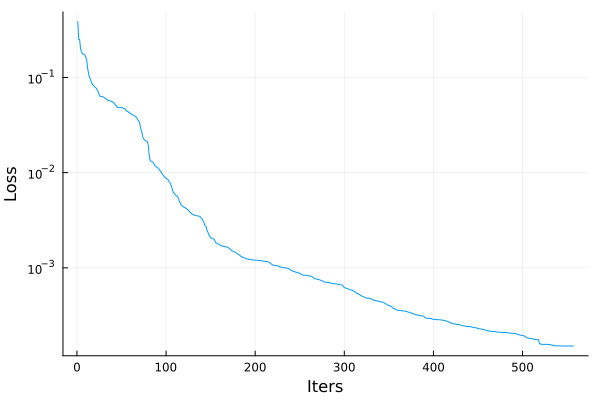

In [10]:
plot(lossrecord, xlabel="Iters", yscale=:log10, ylabel="Loss", lab=false)

Plot the predicted solution of the PDE and compare it with the analytical solution to see the relative error.

In [11]:
xs, ys = [DomainSets.infimum(d.domain):dx/10:DomainSets.supremum(d.domain) for d in domains]
analytic_sol_func(x,y) = (sinpi(x)*sinpi(y))/(2pi^2)

phi = discretization.phi
u_predict = reshape([first(phi([x, y], res.u)) for x in xs for y in ys], (length(xs), length(ys)))
u_real = reshape([analytic_sol_func(x, y) for x in xs for y in ys], (length(xs), length(ys)))
diff_u = abs.(u_predict .- u_real)

201×201 Matrix{Float64}:
 0.00914125  0.00889835  0.00865577  …  0.00216182  0.0023884   0.00261662
 0.00901319  0.00877505  0.00853721     0.00225112  0.00247541  0.00270133
 0.00888442  0.008651    0.00841784     0.00233822  0.00256025  0.0027839
 0.00875498  0.00852622  0.0082977      0.00242315  0.00264295  0.00286437
 0.00862492  0.00840078  0.00817684     0.00250595  0.00272356  0.00294278
 0.00849427  0.0082747   0.0080553   …  0.00258667  0.00280211  0.00301916
 0.00836309  0.00814804  0.00793313     0.00266533  0.00287864  0.00309355
 0.00823141  0.00802084  0.00781038     0.00274197  0.00295319  0.00316598
 0.00809928  0.00789314  0.00768708     0.00281663  0.00302578  0.0032365
 0.00796674  0.00776499  0.00756328     0.00288935  0.00309646  0.00330513
 ⋮                                   ⋱                          ⋮
 0.00137526  0.00132148  0.00126748     0.00535787  0.00549539  0.00563284
 0.00134412  0.00129087  0.00123737     0.00548048  0.00562155  0.00576256
 0.0013127 

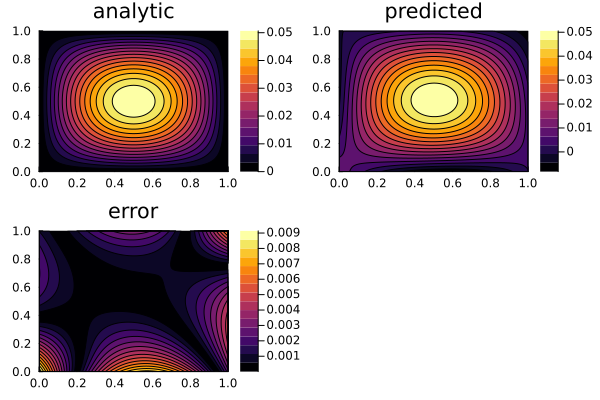

In [12]:
p1 = plot(xs, ys, u_real, linetype=:contourf, title = "analytic");
p2 = plot(xs, ys, u_predict, linetype=:contourf, title = "predicted");
p3 = plot(xs, ys, diff_u, linetype=:contourf, title = "error");
plot(p1, p2, p3)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*